# Train the Generative Model for Accurate Labeling

This notebook is designed to run the generative model snorkel uses for estimating the probability of each candidate being a true candidate (label of 1). 

## MUST RUN AT THE START OF EVERYTHING

Import the necessary modules and set up the database for database operations.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import Counter, OrderedDict, defaultdict
import os
import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_curve, auc

In [2]:
#Set up the environment
username = "danich1"
password = "snorkel"
dbname = "pubmeddb"

#Path subject to change for different os
database_str = "postgresql+psycopg2://{}:{}@/{}?host=/var/run/postgresql".format(username, password, dbname)
os.environ['SNORKELDB'] = database_str

from snorkel import SnorkelSession
session = SnorkelSession()

In [3]:
from snorkel import SnorkelSession
from snorkel.annotations import FeatureAnnotator, LabelAnnotator, save_marginals
from snorkel.learning import GenerativeModel
from snorkel.learning.utils import MentionScorer
from snorkel.models import Candidate, FeatureKey, candidate_subclass, Label
from snorkel.utils import get_as_dict
from tree_structs import corenlp_to_xmltree
from treedlib import compile_relation_feature_generator

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [4]:
edge_type = "dg"

In [5]:
if edge_type == "dg":
    DiseaseGene = candidate_subclass('DiseaseGene', ['Disease', 'Gene'])
elif edge_type == "gg":
    GeneGene = candidate_subclass('GeneGene', ['Gene1', 'Gene2'])
elif edge_type == "cg":
    CompoundGene = candidate_subclass('CompoundGene', ['Compound', 'Gene'])
elif edge_type == "cd":
    CompoundDisease = candidate_subclass('CompoundDisease', ['Compound', 'Disease'])
else:
    print("Please pick a valid edge type")

# Load preprocessed data 

This code will load the label matrix that was generated in the previous notebook ([Notebook 2](2.data-labeler.ipynb)). **Disclaimer**: this block might break, which means that the snorkel code is still using its old code. The problem with the old code is that sqlalchemy will attempt to load all the labels into memory. Doesn't sound bad if you keep the amount of labels small, but doesn't scale when the amount of labels increases exponentially. Good news is that there is a pull request to fix this issue. [Check it out here!](https://github.com/HazyResearch/snorkel/pull/789)

In [6]:
from snorkel.annotations import load_gold_labels
#L_gold_train = load_gold_labels(session, annotator_name='danich1', split=0)
#annotated_cands_train_ids = list(map(lambda x: L_gold_train.row_index[x], L_gold_train.nonzero()[0]))

sql = '''
SELECT candidate_id FROM gold_label
'''
gold_cids = [x[0] for x in session.execute(sql)]
cids = session.query(Candidate.id).filter(Candidate.id.in_(gold_cids))

L_gold_dev = load_gold_labels(session, annotator_name='danich1', cids_query=cids)
annotated_cands_dev_ids = list(map(lambda x: L_gold_dev.row_index[x], L_gold_dev.nonzero()[0]))

In [7]:
L_gold_dev

<1028x1 sparse matrix of type '<class 'numpy.int64'>'
	with 1028 stored elements in Compressed Sparse Row format>

In [8]:
%%time
labeler = LabelAnnotator(lfs=[])

# Only grab candidates that have human labels
#cids = session.query(Candidate.id).filter(Candidate.id.in_(annotated_cands_train_ids))
L_train = labeler.load_matrix(session, split=0) #

cids = session.query(Candidate.id).filter(Candidate.id.in_(gold_cids))
L_dev = labeler.load_matrix(session,cids_query=cids)

CPU times: user 4.69 s, sys: 231 ms, total: 4.92 s
Wall time: 6.77 s


In [9]:
type(L_train)

snorkel.annotations.csr_LabelMatrix

In [10]:
print("Total Data Shape:")
print(L_train.shape)

Total Data Shape:
(2667604, 12)


In [11]:
L_train = L_train[np.unique(L_train.nonzero()[0]), :]
print("Total Data Shape:")
print(L_train.shape)

Total Data Shape:
(10918, 12)


In [12]:
type(L_train)

snorkel.annotations.csr_AnnotationMatrix

# Train the Generative Model

Here is the first step of classification step of this project, where we train a gnerative model to discriminate the correct label each candidate will receive. Snorkel's generative model uses a Gibbs Sampling on a [factor graph](http://deepdive.stanford.edu/assets/factor_graph.pdf), to generate the probability of a potential candidate being a true candidate (label of 1).

In [13]:
%%time
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel()
gen_model.train(
    L_train,
    epochs=30,
    decay=0.95,
    step_size=0.1 / L_train.shape[0],
    reg_param=1e-6,
    threads=50,
    verbose=True
)

Inferred cardinality: 2
FACTOR 0: STARTED BURN-IN...
FACTOR 0: DONE WITH BURN-IN
FACTOR 0: STARTED LEARNING
FACTOR 0: EPOCH #0
Current stepsize = 9.159186664224217e-06
Learning epoch took 0.000 sec.
Weights:
    weightId: 0
        isFixed: True
        weight:  1.0

    weightId: 1
        isFixed: False
        weight:  0.0

    weightId: 2
        isFixed: True
        weight:  1.0

    weightId: 3
        isFixed: False
        weight:  0.0

    weightId: 4
        isFixed: True
        weight:  1.0

    weightId: 5
        isFixed: False
        weight:  0.0

    weightId: 6
        isFixed: True
        weight:  1.0

    weightId: 7
        isFixed: False
        weight:  0.0

    weightId: 8
        isFixed: True
        weight:  1.0

    weightId: 9
        isFixed: False
        weight:  0.0

    weightId: 10
        isFixed: True
        weight:  1.0

    weightId: 11
        isFixed: False
        weight:  0.0

    weightId: 12
        isFixed: True
        weight:  1.0

   

FACTOR 0: EPOCH #5
Current stepsize = 7.087204043780911e-06
Learning epoch took 0.116 sec.
Weights:
    weightId: 0
        isFixed: True
        weight:  1.0

    weightId: 1
        isFixed: False
        weight:  -0.177150531143

    weightId: 2
        isFixed: True
        weight:  1.0

    weightId: 3
        isFixed: False
        weight:  -0.326983544009

    weightId: 4
        isFixed: True
        weight:  1.0

    weightId: 5
        isFixed: False
        weight:  -0.21501167069

    weightId: 6
        isFixed: True
        weight:  1.0

    weightId: 7
        isFixed: False
        weight:  -0.398161198034

    weightId: 8
        isFixed: True
        weight:  1.0

    weightId: 9
        isFixed: False
        weight:  -0.233547697249

    weightId: 10
        isFixed: True
        weight:  1.0

    weightId: 11
        isFixed: False
        weight:  -0.402176090302

    weightId: 12
        isFixed: True
        weight:  1.0

    weightId: 13
        isFixed: False


FACTOR 0: EPOCH #10
Current stepsize = 5.4839433892505836e-06
Learning epoch took 0.113 sec.
Weights:
    weightId: 0
        isFixed: True
        weight:  1.0

    weightId: 1
        isFixed: False
        weight:  -0.27266571213

    weightId: 2
        isFixed: True
        weight:  1.0

    weightId: 3
        isFixed: False
        weight:  -0.496103272929

    weightId: 4
        isFixed: True
        weight:  1.0

    weightId: 5
        isFixed: False
        weight:  -0.328877489763

    weightId: 6
        isFixed: True
        weight:  1.0

    weightId: 7
        isFixed: False
        weight:  -0.594034588155

    weightId: 8
        isFixed: True
        weight:  1.0

    weightId: 9
        isFixed: False
        weight:  -0.36726988689

    weightId: 10
        isFixed: True
        weight:  1.0

    weightId: 11
        isFixed: False
        weight:  -0.611476795163

    weightId: 12
        isFixed: True
        weight:  1.0

    weightId: 13
        isFixed: False

FACTOR 0: EPOCH #15
Current stepsize = 4.2433708569312425e-06
Learning epoch took 0.100 sec.
Weights:
    weightId: 0
        isFixed: True
        weight:  1.0

    weightId: 1
        isFixed: False
        weight:  -0.326749612175

    weightId: 2
        isFixed: True
        weight:  1.0

    weightId: 3
        isFixed: False
        weight:  -0.585836838335

    weightId: 4
        isFixed: True
        weight:  1.0

    weightId: 5
        isFixed: False
        weight:  -0.39464460875

    weightId: 6
        isFixed: True
        weight:  1.0

    weightId: 7
        isFixed: False
        weight:  -0.69616821315

    weightId: 8
        isFixed: True
        weight:  1.0

    weightId: 9
        isFixed: False
        weight:  -0.450383296

    weightId: 10
        isFixed: True
        weight:  1.0

    weightId: 11
        isFixed: False
        weight:  -0.727631002667

    weightId: 12
        isFixed: True
        weight:  1.0

    weightId: 13
        isFixed: False
  

FACTOR 0: EPOCH #20
Current stepsize = 3.283439479836434e-06
Learning epoch took 0.112 sec.
Weights:
    weightId: 0
        isFixed: True
        weight:  1.0

    weightId: 1
        isFixed: False
        weight:  -0.360279845266

    weightId: 2
        isFixed: True
        weight:  1.0

    weightId: 3
        isFixed: False
        weight:  -0.637742612984

    weightId: 4
        isFixed: True
        weight:  1.0

    weightId: 5
        isFixed: False
        weight:  -0.432342097805

    weightId: 6
        isFixed: True
        weight:  1.0

    weightId: 7
        isFixed: False
        weight:  -0.756572810698

    weightId: 8
        isFixed: True
        weight:  1.0

    weightId: 9
        isFixed: False
        weight:  -0.508793462475

    weightId: 10
        isFixed: True
        weight:  1.0

    weightId: 11
        isFixed: False
        weight:  -0.798855654827

    weightId: 12
        isFixed: True
        weight:  1.0

    weightId: 13
        isFixed: Fals

FACTOR 0: EPOCH #25
Current stepsize = 2.5406628789323477e-06
Learning epoch took 0.137 sec.
Weights:
    weightId: 0
        isFixed: True
        weight:  1.0

    weightId: 1
        isFixed: False
        weight:  -0.383293126808

    weightId: 2
        isFixed: True
        weight:  1.0

    weightId: 3
        isFixed: False
        weight:  -0.67253331019

    weightId: 4
        isFixed: True
        weight:  1.0

    weightId: 5
        isFixed: False
        weight:  -0.457383483931

    weightId: 6
        isFixed: True
        weight:  1.0

    weightId: 7
        isFixed: False
        weight:  -0.794588298526

    weightId: 8
        isFixed: True
        weight:  1.0

    weightId: 9
        isFixed: False
        weight:  -0.547221127131

    weightId: 10
        isFixed: True
        weight:  1.0

    weightId: 11
        isFixed: False
        weight:  -0.843389911425

    weightId: 12
        isFixed: True
        weight:  1.0

    weightId: 13
        isFixed: Fals

FACTOR 0: DONE WITH LEARNING
CPU times: user 15 s, sys: 75.7 ms, total: 15.1 s
Wall time: 5.93 s


In [14]:
gen_model.weights.lf_accuracy

array([ 0.60035882,  0.30446119,  0.52520227,  0.18155286,  0.42320114,
        0.12567208,  0.20859564,  0.22550155,  0.12969563,  0.13175861,
        0.12336706,  0.12962304])

In [15]:
from utils.disease_gene_lf import LFS
learned_stats_df = gen_model.learned_lf_stats()
learned_stats_df.index = list(LFS)
learned_stats_df

,Accuracy,Coverage,Precision,Recall
LF_HETNET_DISEASES,0.774868,0.7027,0.775499,0.542123
LF_HETNET_DOAF,0.637387,0.6751,0.648121,0.436168
LF_HETNET_DisGeNET,0.744374,0.6932,0.752467,0.516431
LF_HETNET_GWAS,0.600636,0.6603,0.601449,0.396734
LF_HETNET_ABSENT,0.704021,0.6889,0.704168,0.481179
LF_CHECK_GENE_TAG,0.558222,0.6750,0.558885,0.375224
LF_IS_BIOMARKER,0.602687,0.6700,0.605679,0.412069
LF_ASSOCIATION,0.609658,0.6730,0.605926,0.407289
LF_NO_ASSOCIATION,0.562224,0.6565,0.557194,0.368652
LF_NO_CONCLUSION,0.567429,0.6644,0.574205,0.370643


In [16]:
%time train_marginals = gen_model.marginals(L_train)

CPU times: user 4.04 s, sys: 0 ns, total: 4.04 s
Wall time: 4.04 s


In [17]:
print(len(train_marginals[train_marginals > 0.5]))

6182


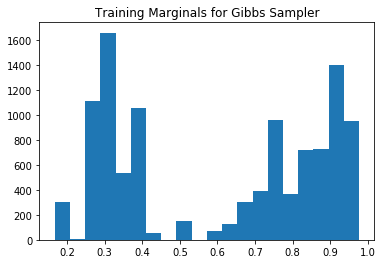

In [18]:
plt.hist(train_marginals, bins=20)
plt.title("Training Marginals for Gibbs Sampler")
plt.show()

In [19]:
tp, fp, tn, fn = gen_model.error_analysis(session, L_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.969
Neg. class accuracy: 0.0853
Precision            0.478
Recall               0.969
F1                   0.64
----------------------------------------
TP: 462 | FP: 504 | TN: 47 | FN: 15



In [20]:
dev_marginals = gen_model.marginals(L_dev)

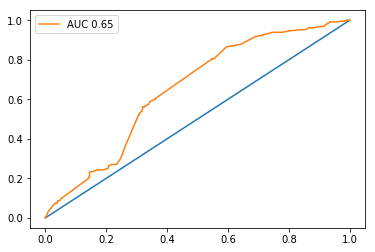

In [21]:
fpr, tpr, threshold = roc_curve(L_gold_dev.todense(), dev_marginals)
plt.plot([0,1], [0,1])
plt.plot(fpr, tpr, label='AUC {:.2f}'.format(auc(fpr, tpr)))
plt.legend()

In [ ]:
from snorkel.viewer import SentenceNgramViewer

# NOTE: This if-then statement is only to avoid opening the viewer during automated testing of this notebook
# You should ignore this!
import os
if 'CI' not in os.environ:
    sv = SentenceNgramViewer(fp, session)
else:
    sv = None

In [ ]:
sv

In [ ]:
c = sv.get_selected() if sv else list(fp.union(fn))[0]
c

In [22]:
rows = list()
for i in range(L_train.shape[0]):
    row = OrderedDict()
    candidate = L_train.get_candidate(session, i)
    row['disease'] = candidate[0].get_span()
    row['gene'] = candidate[1].get_span()
    row['doid_id'] = candidate.Disease_cid
    row['entrez_gene_id'] = candidate.Gene_cid
    row['sentence'] = candidate.get_parent().text
    row['label'] = train_marginals[i]
    rows.append(row)
sentence_df = pd.DataFrame(rows)

sentence_df = pd.concat([
    sentence_df,
    pd.DataFrame(L_train.todense(), columns=list(LFS))
], axis='columns')

sentence_df.tail()

,disease,gene,doid_id,entrez_gene_id,sentence,label,LF_HETNET_DISEASES,LF_HETNET_DOAF,LF_HETNET_DisGeNET,LF_HETNET_GWAS,LF_HETNET_ABSENT,LF_CHECK_GENE_TAG,LF_IS_BIOMARKER,LF_ASSOCIATION,LF_NO_ASSOCIATION,LF_NO_CONCLUSION,LF_DG_DISTANCE,LF_NO_VERB
10913,Bipolar Disorder,Phospho-Ser-9-GSK-3b,DOID:3312,2932,Lymphocyte Phospho-Ser-9-GSK-3b/Total GSK-3b P...,0.931419,1,1,1,0,0,-1,0,0,0,0,0,0
10914,glioma,LGR5,DOID:3070,8549,"Taken together, these findings suggest a tumor...",0.300188,0,0,0,0,-1,0,0,0,0,0,0,0
10915,PD,FOG,DOID:14330,161882,OBJECTIVE: To examine potential differences in...,0.251028,0,0,0,0,-1,0,0,0,0,0,-1,0
10916,PXA,BRAF,DOID:0060073,673,CDKN2A/B deletion was present in similar propo...,0.300188,0,0,0,0,-1,0,0,0,0,0,0,0
10917,breast cancer,TMSB10,DOID:1612,9168,RESULTS: We found TMSB10 was upregulated in br...,0.300188,0,0,0,0,-1,0,0,0,0,0,0,0


In [23]:
writer = pd.ExcelWriter('data/sentence-labels.xlsx')
sentence_df.to_excel(writer, sheet_name='sentences', index=False)
if writer.engine == 'xlsxwriter':
    for sheet in writer.sheets.values():
        sheet.freeze_panes(1, 0)
writer.close()

In [ ]:
sentence_df

In [ ]:
c.labels

In [ ]:
L_dev.get_row_index(c)

In [ ]:
dev_marginals[26]

In [ ]:
L_dev.lf_stats(session, L_gold_dev[L_gold_dev!=0].T, gen_model.learned_lf_stats()['Accuracy'])

# Save Training Marginals

Save the training marginals for [Notebook 4](4.data-disc-model).

In [ ]:
np.savetxt("vanilla_lstm/lstm_disease_gene_holdout/subsampled/train_marginals_subsampled.txt", train_marginals)

In [ ]:
#%time save_marginals(session, L_train, train_marginals)